# Probability Calibration for Binary Classification of Unbalanced Data

A predictor is called well-calibrated if the derived predictive confidence represents a good approximation of the actual
probability of correctness [Reference](https://arxiv.org/pdf/2107.03342.pdf). In the reference survey paper three main methods of calibration are reviewed:
- Regularization: In principle the objective function is modified to force the optimization minimize the model uncertainty.
- Post-processing: Simple example of this is shown later in this notebook.
- Calibration with uncertainty estimation approaches: These aim to remove model uncertainty and estimate the data uncertainty by ensemble technique or using Bayesian NN.

This notebooks shows the principle of probability calibration in post-processing. 

When dealing with classification of highly unbalanced datasets the output of a NN does not correspond to the true probability of a class. The main reason for that is that during the training the class(es) with less probability need to be oversampled, otherwise the NN would converge to trivial states and assign all the outputs to the most probable classes and still achieve low loss and high total accuracy. 

Even when the classes are balanced, for deeper NN, regularization techniques need to be applied to overcome overfitting. These also make the scores of the classes to deviate from the true probability.

For unbalanced datasets, the output scores of the classes cannot be so useful on their own or at least they cannot be easily interpreted. For example, in a ranking system for a recommendation system the scores can still be used for recommending the top-K items, but they don't translate the probability that the user may pick them. 

To make them more useful, calibration of the scores is performed to map the scores of a query to the probability of that score. 

The main principle is that first a model (like a NN) is trained on a training set, then a smaller calibration set is used to fit the parameters of a function f(x) where x is the score from the model. The output of the function f(x) is expected to be equal to p, the actual probability of the similar scores to be in a class. The calibration set can be small, as the number of parameters in the function f is usually small.

The four main methods/functions for the calibration are:
- Platt [Platt](https://en.wikipedia.org/wiki/Platt_scaling)
- Beta  [Beta](https://proceedings.mlr.press/v54/kull17a.html)
- Spline [Spline](https://arxiv.org/abs/1809.07751)
- Isotonic [Isotonic](https://en.wikipedia.org/wiki/Isotonic_regression)

In this notebook Platt and Beta calibration are applied to [Dataset](https://www.nature.com/articles/sdata201635.pdf)

In this notebook:
- Using [ml_insight](https://pypi.org/project/ml-insights/) library for probability calibration
- Platt and Beta probability calibration on three models (Random Forrest, three layer NN, Logistic Regression)
- Applying oversampling to train NN for binary classification in an unbalanced dataset.


## Loading libraries

In [1]:
# pytorch used for NN implementation 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, WeightedRandomSampler, Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from betacal import BetaCalibration

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")
print(f"Available device is {DEVICE}")

Available device is cuda


## Loading the data

and visualizing it.

In [2]:
DataFrame = pd.read_csv("data/lab_vital_icu_table.csv")
DataFrame.head()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333


There are many empty cells with values of NaN. Their value is replaced by the median of the column.

In [3]:
for i in range(len(DataFrame.columns)):
    if DataFrame.iloc[:,i].dtype !='O':
        DataFrame.iloc[:,i].fillna(DataFrame.iloc[:,i].median(),inplace=True)
DataFrame.head()

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,3.1,3.2,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,3.1,3.2,21.0,21.0,0.7,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,3.1,3.2,23.0,23.0,0.7,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,3.1,3.2,33.0,35.0,0.7,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333


## Data preprocessing

There are 70 columns in the data but not all of them are good to be used as a feature for the detection. A set of 16 features is selected for predicting if the likelihood of the patient dying.

The columns from the selected features are stored in X and the column showing if the patient died is stored in column y.

In [4]:
features = ['bun_min', 'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_min', 'lactate_min', 'lactate_max', 
            'platelet_min', 'platelet_max', 'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min', 'inr_max']

X = DataFrame.loc[:, features]
y = DataFrame['hospital_expire_flag']

Using sklearn the data is split between training and test. The training data will again be split between training and calibration.

In [5]:
X_train_cal, X_test, y_train_cal, y_test = train_test_split(X, y, test_size=0.35, random_state = 42)

In [6]:
X_train, X_cal, y_train, y_cal = train_test_split(X_train_cal, y_train_cal, test_size = 0.15, random_state = 42)

Checking the number of samples in each dataset

In [7]:
X_train.shape, X_cal.shape, X_test.shape

((32997, 16), (5824, 16), (20905, 16))

y (label) equal to 1, means that the patient died. Checking the frequency and number of occurance of 1 in the train dataset we can see that the number of samples with y == 1 is 10 time lower that y == 1 and we have a highly unbalanced dataset.

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 29398]
 [    1  3599]]


# Probability Calibration Procedure

The following steps are followed for probability calibration on different models:
- Selecting a model and fiting it to the train dataset.
- Extracting the scores (uncalibrated probabilities) on test dataset passing the test dataset to the fitted model.
- Visualizing the reliability diagram of the predicted scores vs. emperical probabilities (on test dataset)
- Selecting a calibration method and fitting its function to the calibration dataset.
- Predicting the (calibrated) probabilities by passing the scores (from step 2) to the fitted calibration function.
- Visualizing the fitted function and checking how well it corresponds to the calibration and the test dataset.
- Visualizing the the reliability diagram of the predicted (calibrated) probability vs. emperical probabilities (on test dataset)

The three models are:
- Random Forrest
- NN
- Logistic Regression

and the two calibration functions are:
- Platt
- Beta

## Random Forrest Model with Platt

#### Step 1:

In [9]:
randomForrest = RandomForestClassifier(n_estimators = 300, class_weight='balanced_subsample', 
                                  random_state = 42, n_jobs = -1 )
randomForrest.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       n_jobs=-1, random_state=42)

#### Step 2:

In [10]:
probs_test_rf = randomForrest.predict_proba(X_test)[:,1]

#### Step 3:

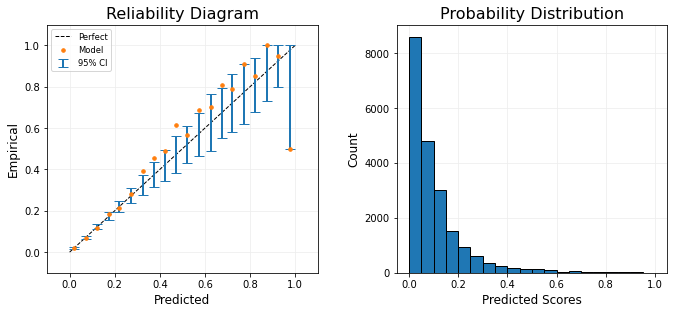

In [11]:
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test, probs_test_rf, show_histogram=True);

#### Step 4: Platt

Platt is in principle a logistic regression relation between the scores and the true labels.

In [12]:
probs_cal_rf = randomForrest.predict_proba(X_cal)[:,1]
logisticReggression = LogisticRegression(C=99999999999, solver='lbfgs')
logisticReggression.fit(probs_cal_rf.reshape(-1,1), y_cal)

LogisticRegression(C=99999999999)

#### Step 5: 

Passing the scores from calibration and test dataset to the Platt function to get calibrated/predicted probabilities.

In [13]:
probs_cal_rf_platt  = logisticReggression.predict_proba(probs_cal_rf.reshape(-1,1))[:,1]
probs_test_rf_platt = logisticReggression.predict_proba(probs_test_rf.reshape(-1,1))[:,1]

#### Step 6:

The blue lines shows the fitted function.
The red markers show the points from the calibration dataset. There are less points in this dataset so the bins may not have many points, specially for higher scores because of unbalanced data, so the points are noisier.
The black markers show the points from the test dataset.

plot_reliability_diagram method from [ml_insight](https://ml-insights.readthedocs.io/en/latest/) goes over the dataset, bins the scores (can be customized). Then, for each bin of scores, from the labels calculates the true/emperical probability of the bin. Therefore, each point is shows as its emperical probability vs. (model) predicted score.

Logistic regression does not have many parameters and we can see that the best fit is not exactly going true the points but on average this results in lowest fitting error for the points from the calibration set. We can note that it also looks reasonable for the test dataset.


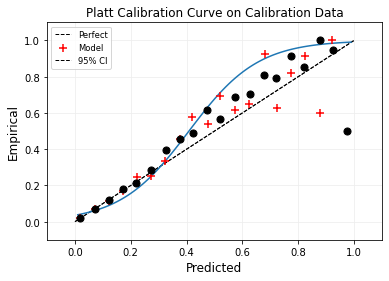

In [14]:
mli.plot_reliability_diagram(y_cal, probs_cal_rf, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_rf, error_bars=False,marker = 'o', marker_color = 'black', marker_edge_color='black');
line = np.linspace(.01, .99, 99)
plt.plot(line, logisticReggression.predict_proba(line.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');


#### Step 7

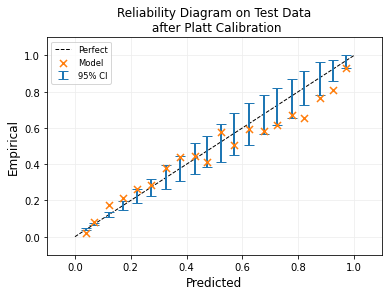

In [15]:
mli.plot_reliability_diagram(y_test, probs_test_rf_platt, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

## Random Forrest Model with Beta

Steps 1-3 are common and data exists so we start from step 4.

#### Step 4:

In [16]:
betaCalibration = BetaCalibration()
betaCalibration.fit(probs_cal_rf, y_cal)

BetaCalibration()

#### Step 5:

In [17]:
probs_cal_rf_beta  = betaCalibration.predict(probs_cal_rf)
probs_test_rf_beta = betaCalibration.predict(probs_test_rf)

#### Step 6:

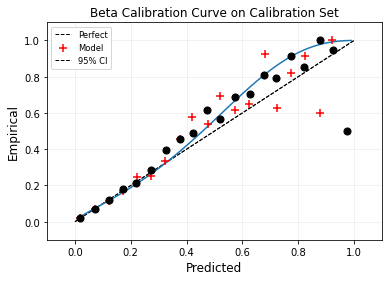

In [18]:
mli.plot_reliability_diagram(y_cal, probs_cal_rf, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_rf, error_bars=False, marker = 'o', marker_color = 'black', marker_edge_color='black');

plt.plot(line, betaCalibration.predict(line))
plt.title('Beta Calibration Curve on Calibration Set');

#### Step 5:

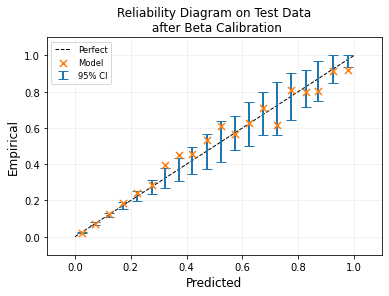

In [19]:
mli.plot_reliability_diagram(y_test, probs_test_rf_beta, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

## NN Model with Platt

To train a NN on this data we have to do additional pre-processing steps:
- Using sklearn to scale the data
- Setting up training dataloader with oversampling so that the outcome of the training is not trivial

#### Scaling the data

In [20]:
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
y_train = y_train.values
x_test = sc.fit_transform(X_test)
y_test = y_test.values
x_cal = sc.fit_transform(X_cal)
y_cal = y_cal.values

### Setting up the dataloaders

The test dataloader does not do oversampling and can be easily made.
Not that the simple trainloader that is commented out below is an example of how it should NOT be done.

In [21]:
class dataset(Dataset):
    def __init__(self, x, y):
        #super(dataset, self).__init__()
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(x_train,y_train)
testset  = dataset(x_test,y_test)

#trainloader = DataLoader(trainset,batch_size=1024,shuffle=False)
testloader = DataLoader(testset,batch_size=1024,shuffle=False)

A sampler is created using pytorch WeightedRandomSampler. The weights are assigned to the each sample in the train dataset based on its label.

In [22]:
label_unique, counts = np.unique(y_train, return_counts = True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in y_train]
sampler = WeightedRandomSampler(example_weights, len(y_train))
trainloader = DataLoader(trainset, sampler=sampler,batch_size=128,shuffle=False)

### Setting up the NN model

Simple NN with three dense/linear layers is created. No regularization or dropout is applied.

In [23]:
class Net(nn.Module):
    
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,10)
        self.fc2 = nn.Linear(10,8)
        self.fc3 = nn.Linear(8,1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)
        
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
    
def evaluate(testloader):
    loss = 0
    acc_t  = 0
    for j, (x_t, y_t) in enumerate(tqdm(testloader, colour = 'blue')):
        x_t = x_t.to(DEVICE)
        #y_test = y_test.to(DEVICE)
        with torch.no_grad():
            predicted = model(x_t)
        acc_batch = (predicted.detach().cpu().numpy().round() == y_test).mean()
        acc_t += acc_batch
    return acc_t / len(testloader)


#### Defining parameters and metrics 

In [24]:
learning_rate = 0.01
epochs = 10
model = Net(input_shape=x_train.shape[1]).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()
print(model)

Net(
  (fc1): Linear(in_features=16, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


Now after these preprocessing steps, we are ready to follow the steps and fit the model to the training dataset.

#### Step 1:

In [25]:
losses = []
accur = []
model.train()
model.to(DEVICE)
epochs = 20
acc = evaluate(testloader=testloader)
print("Starting accuracy : {}".format(acc))

for i in range(epochs):
    for j,(x_,y_) in enumerate(tqdm(trainloader, colour = 'green')):
        
        x_ = x_.to(DEVICE)
        y_ = y_.to(DEVICE)
        output = model(x_)
        
        loss = loss_fn(output,y_.reshape(-1,1))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    acc = evaluate(testloader=testloader)
    
    if i%1 == 0:
        losses.append(loss.detach().cpu())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

  0%|          | 0/21 [00:00<?, ?it/s]

Starting accuracy : 0.3088813439436406


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0	loss : 0.6496283411979675	 accuracy : 0.5450155568782465


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 1	loss : 0.6175558567047119	 accuracy : 0.6557759122693566


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 2	loss : 0.590628445148468	 accuracy : 0.692317498467038


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 3	loss : 0.6007922887802124	 accuracy : 0.7108494899551845


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 4	loss : 0.6345371603965759	 accuracy : 0.7144801646830702


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 5	loss : 0.5457069277763367	 accuracy : 0.7210719151224827


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 6	loss : 0.5605120658874512	 accuracy : 0.7145380185858128


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 7	loss : 0.5369008183479309	 accuracy : 0.7167269672107364


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 8	loss : 0.5198549628257751	 accuracy : 0.707580830032922


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 9	loss : 0.5574375987052917	 accuracy : 0.7129210191206954


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 10	loss : 0.5288649201393127	 accuracy : 0.7056579580109968


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 11	loss : 0.5456939339637756	 accuracy : 0.7133425994829887


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 12	loss : 0.513877272605896	 accuracy : 0.7068450755922735


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 13	loss : 0.5997015833854675	 accuracy : 0.6971616502466809


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 14	loss : 0.5551590919494629	 accuracy : 0.703316928934633


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 15	loss : 0.5479529500007629	 accuracy : 0.7077692831303175


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 16	loss : 0.5642295479774475	 accuracy : 0.6968128151762978


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 17	loss : 0.5268792510032654	 accuracy : 0.7008006264961137


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 18	loss : 0.5917062759399414	 accuracy : 0.6927522585645715


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 19	loss : 0.5268234610557556	 accuracy : 0.699162145774209


#### Step 2:

In [26]:
x_test_cuda = torch.tensor(x_test, dtype = torch.float32).to(DEVICE)
probs_test_net = model(x_test_cuda).detach().cpu().numpy().squeeze()

#### Step 3:

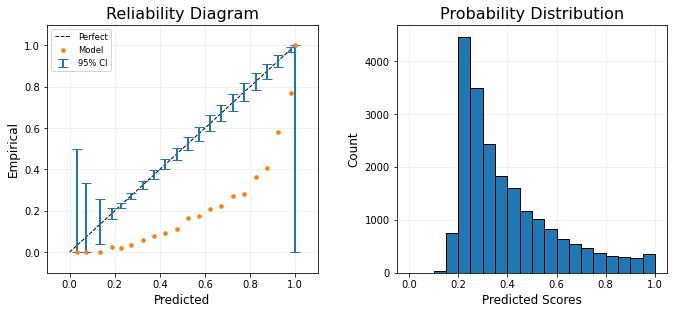

In [27]:
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test, probs_test_net, show_histogram=True);

#### Other observations:

The performance is quiet different from the Random Forrest. In the first look it may seem that this would not be useful. The application of this model will depend on what is the goal of the prediction, based on that a threshold should is applied to the score to assign it to a class.

ROC score can be calculated using sklearn library and its value is similar to the score from the random forrest model.
We can also quickly check the confusion matrix for different values of a threshold and note the trade-off between precision and recall.

We can see that the scores generally overestimate the probabilities. For example if the threshold is set to 0.5, only 10% of the datapoints would actually have label of 1, but we are expecting 50% of them to be positive.

In [28]:
roc_auc_score(y_test, probs_test_net)

0.7997709753376773

In [29]:
print("Threshold set to 0.5:")
predictions_p5_threshold = probs_test_net.round()
print("Example of labels:")
print(predictions_p5_threshold[:25])
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predictions_p5_threshold)
print(cm)

print("Threshold set to 0.2:")
predictions_p2_threshold = [1 if p > 0.2 else 0 for p in probs_test_net]
print("Example of labels:")
print(predictions_p2_threshold[:25])
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predictions_p2_threshold)
print(cm)

print("Threshold set to 0.9:")
predictions_p9_threshold = [1 if p > 0.9 else 0 for p in probs_test_net]
print("Example of labels:")
print(predictions_p9_threshold[:25])
print("Confusion Matrix:")
cm = confusion_matrix(y_test, predictions_p9_threshold)
print(cm)

Threshold set to 0.5:
Example of labels:
[0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 1.]
Confusion Matrix:
[[14976  3652]
 [  802  1475]]
Threshold set to 0.2:
Example of labels:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Confusion Matrix:
[[  767 17861]
 [   18  2259]]
Threshold set to 0.9:
Example of labels:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Confusion Matrix:
[[18425   203]
 [ 1834   443]]


#### Step 4: 

In [30]:
x_cal_cuda = torch.tensor(x_cal, dtype = torch.float32).to(DEVICE)
probs_cal_net = model(x_cal_cuda).detach().cpu().numpy().squeeze()

In [31]:
logisticReggression = LogisticRegression(C=99999999999, solver='lbfgs')
logisticReggression.fit(probs_cal_net.reshape(-1,1), y_cal)

LogisticRegression(C=99999999999)

#### Step 5: 

In [32]:
probs_cal_net_platt  = logisticReggression.predict_proba(probs_cal_net.reshape(-1,1))[:,1]
probs_test_net_platt = logisticReggression.predict_proba(probs_test_net.reshape(-1,1))[:,1]

#### Step 6: 

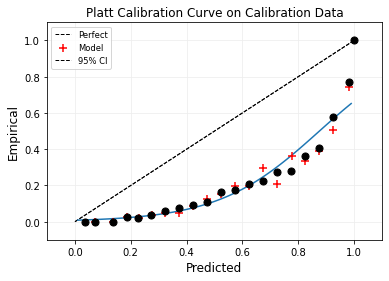

In [33]:
mli.plot_reliability_diagram(y_cal, probs_cal_net, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_net, error_bars=False, marker = 'o', marker_color = 'black', marker_edge_color='black');

plt.plot(line, logisticReggression.predict_proba(line.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');

#### Step 7: 

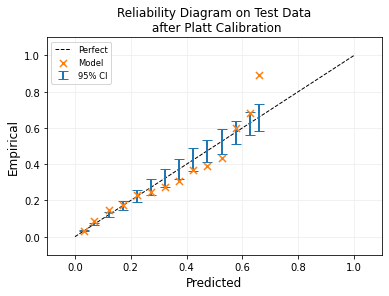

In [34]:
mli.plot_reliability_diagram(y_test, probs_test_net_platt, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

Platt does not have too much freedom and cannot sometime fit to the data so we can not some outliers that are now understimating the probabilties.

## NN Model with Beta

Steps 1-3 are common and data exists. 

#### Step 4: 

In [35]:
betaCalibration = BetaCalibration()
betaCalibration.fit(probs_cal_net, y_cal)

BetaCalibration()

#### Step 5: 

In [36]:
probs_cal_net_beta  = betaCalibration.predict(probs_cal_net)
probs_test_net_beta = betaCalibration.predict(probs_test_net)

#### Step 6: 

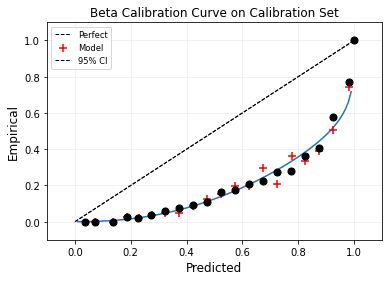

In [37]:
mli.plot_reliability_diagram(y_cal, probs_cal_net, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_net, error_bars=False, marker = 'o', marker_color = 'black', marker_edge_color='black');

plt.plot(line, betaCalibration.predict(line))
plt.title('Beta Calibration Curve on Calibration Set');

#### Step 6: 

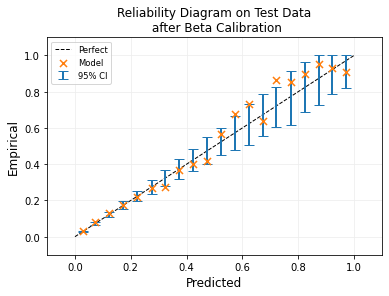

In [38]:
mli.plot_reliability_diagram(y_test, probs_test_net_beta, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');

With more freedom that the Beta has, it can very nicely fit to the points and it seems are the calibrated predictions are within the range.

## Logistic Regression with Platt

This is very similar to the previous NN model. The pre-processing is already done and we can start the training in step 1 after defining the model.

In [39]:
class NetL(nn.Module):
    
    def __init__(self,input_shape):
        super(NetL,self).__init__()
        self.fc1 = nn.Linear(input_shape,1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        
    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
def evaluateL(testloader):
    loss = 0
    acc_t  = 0
    for j, (x_t, y_t) in enumerate(tqdm(testloader, colour = 'blue')):
        x_t = x_t.to(DEVICE)
        #y_test = y_test.to(DEVICE)
        with torch.no_grad():
            predicted = modelL(x_t)
        acc_batch = (predicted.detach().cpu().numpy().round() == y_test).mean()
        acc_t += acc_batch
    return acc_t / len(testloader)

#### Defining parameters

In [40]:
learning_rate = 0.01
epochs = 10
modelL = NetL(input_shape=x_train.shape[1]).to(DEVICE)
optimizerL = torch.optim.SGD(modelL.parameters(),lr=learning_rate)
loss_fnL = nn.BCELoss()
print(modelL)

NetL(
  (fc1): Linear(in_features=16, out_features=1, bias=True)
)


In [41]:
losses = []
accur = []
modelL.train()
modelL.to(DEVICE)

acc = evaluateL(testloader=testloader)
print("Starting accuracy : {}".format(acc))

for i in range(epochs):
    for j,(x_,y_) in enumerate(tqdm(trainloader, colour = 'green')):
        
        x_ = x_.to(DEVICE)
        y_ = y_.to(DEVICE)
        output = modelL(x_)
        
        loss = loss_fnL(output,y_.reshape(-1,1))

        optimizerL.zero_grad()
        loss.backward()
        optimizerL.step()
        
        
    acc = evaluateL(testloader=testloader)
    
    if i%1 == 0:
        losses.append(loss.detach().cpu())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

  0%|          | 0/21 [00:00<?, ?it/s]

Starting accuracy : 0.516520883706269


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 0	loss : 0.5642905235290527	 accuracy : 0.605664162570673


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 1	loss : 0.5635019540786743	 accuracy : 0.6543573790771091


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 2	loss : 0.6414098143577576	 accuracy : 0.6804268097994999


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 3	loss : 0.5667833685874939	 accuracy : 0.68689455091188


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 4	loss : 0.5699979662895203	 accuracy : 0.6935309755187952


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 5	loss : 0.5573453307151794	 accuracy : 0.695967942797784


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 6	loss : 0.547501802444458	 accuracy : 0.6966441316817625


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 7	loss : 0.5412200093269348	 accuracy : 0.6966143489034277


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 8	loss : 0.5686283111572266	 accuracy : 0.6984412827227278


  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

epoch 9	loss : 0.6517229676246643	 accuracy : 0.6991902168986167


#### Step 2: 

In [42]:
x_test_cuda = torch.tensor(x_test, dtype = torch.float32).to(DEVICE)
probs_test_netL = modelL(x_test_cuda).detach().cpu().numpy().squeeze()

#### Step 3: 

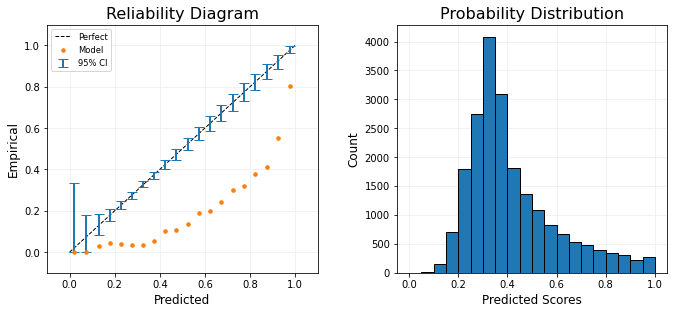

In [43]:
plt.figure(figsize=(10,5))
mli.plot_reliability_diagram(y_test, probs_test_netL, show_histogram=True);

ROC_AUC score is lower than NN:

In [44]:
roc_auc_score(y_test, probs_test_netL)

0.7754590395180531

#### Step 4:

In [45]:
x_cal_cuda = torch.tensor(x_cal, dtype = torch.float32).to(DEVICE)
probs_cal_netL = modelL(x_cal_cuda).detach().cpu().numpy().squeeze()

In [46]:
logisticReggression2 = LogisticRegression(C=99999999999, solver='lbfgs')
logisticReggression2.fit(probs_cal_netL.reshape(-1,1), y_cal)

LogisticRegression(C=99999999999)

#### Step 5: 

In [47]:
probs_cal_netL_platt  = logisticReggression2.predict_proba(probs_cal_netL.reshape(-1,1))[:,1]
probs_test_netL_platt = logisticReggression2.predict_proba(probs_test_netL.reshape(-1,1))[:,1]

#### Step 6: 

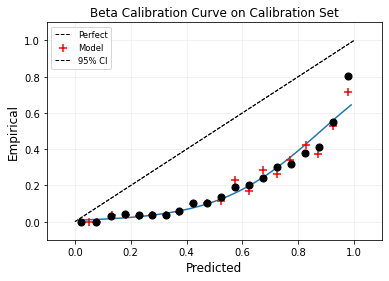

In [48]:
mli.plot_reliability_diagram(y_cal, probs_cal_netL, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_netL, error_bars=False, marker = 'o', marker_color = 'black', marker_edge_color='black');

plt.plot(line, logisticReggression2.predict_proba(line.reshape(-1,1))[:,1])
plt.title('Beta Calibration Curve on Calibration Set');

#### Step 7: 

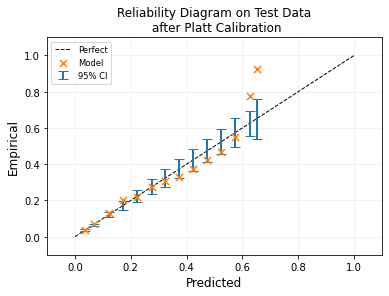

In [49]:
mli.plot_reliability_diagram(y_test, probs_test_netL_platt, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Platt Calibration');

## Logistic Regression with Beta

Once again, steps 1-3 are common and we start from step 4.

#### Step 4:

In [50]:
betaCalibration = BetaCalibration()
betaCalibration.fit(probs_cal_netL, y_cal)

BetaCalibration()

#### Step 5:

In [51]:
probs_cal_netL_beta  = betaCalibration.predict(probs_cal_net)
probs_test_netL_beta = betaCalibration.predict(probs_test_net)

#### Step 6:

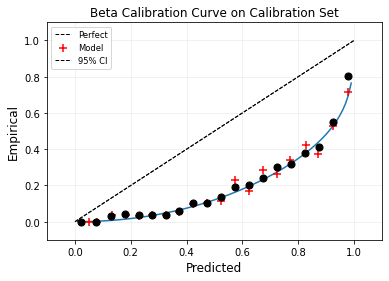

In [52]:
mli.plot_reliability_diagram(y_cal, probs_cal_netL, error_bars=False, marker = '+', marker_color = 'red', marker_edge_color='red');
mli.plot_reliability_diagram(y_test, probs_test_netL, error_bars=False, marker = 'o', marker_color = 'black', marker_edge_color='black');
plt.plot(line, betaCalibration.predict(line))
plt.title('Beta Calibration Curve on Calibration Set');

#### Step 7

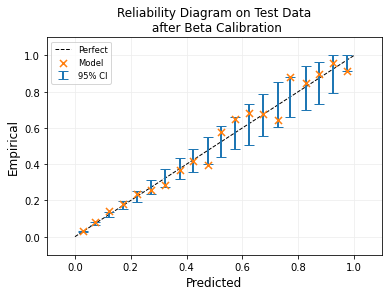

In [53]:
mli.plot_reliability_diagram(y_test, probs_test_netL_beta, marker = 'x');
plt.title('Reliability Diagram on Test Data\n after Beta Calibration');